# pip & import

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.6 MB/s eta 0:00:00


In [ ]:
import os
import random
import numpy as np
import pandas as pd

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager as fm

# 서울 평균

## seed 고정 & 함수 정의


In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

## 데이터 불러오기



In [ ]:
train_org = pd.read_csv('train.csv')
sample_submission = pd.read_csv("sample_submission.csv")

In [ ]:
train_df = train_org.copy()

In [ ]:
test_df = sample_submission.copy()

In [ ]:
train_df

,일시,최고기온,최저기온,일교차,강수량,평균습도,평균풍속,일조합,일사합,일조율,평균기온
0,1960-01-01,2.2,-5.2,7.4,NaN,68.3,1.7,6.7,NaN,NaN,-1.6
1,1960-01-02,1.2,-5.6,6.8,0.4,87.7,1.3,0.0,NaN,NaN,-1.9
2,1960-01-03,8.7,-2.1,10.8,0.0,81.3,3.0,0.0,NaN,NaN,4.0
3,1960-01-04,10.8,1.2,9.6,0.0,79.7,4.4,2.6,NaN,NaN,7.5
4,1960-01-05,1.3,-8.2,9.5,NaN,44.0,5.1,8.2,NaN,NaN,-4.6
...,...,...,...,...,...,...,...,...,...,...,...
23006,2022-12-27,3.3,-7.3,10.6,NaN,69.8,1.8,8.8,10.25,91.7,-2.6
23007,2022-12-28,0.1,-6.0,6.1,0.1,58.1,2.5,8.7,10.86,90.6,-3.3
23008,2022-12-29,2.1,-7.8,9.9,0.0,56.3,1.7,9.0,10.88,93.8,-2.9
23009,2022-12-30,2.3,-4.4,6.7,0.0,65.6,1.9,7.9,10.84,82.3,-1.8


## **데이터 전처리**  

In [ ]:
# '일시' 컬럼을 datetime 형식으로 변환하고, Feature을 추출
train_df['일시'] = pd.to_datetime(train_df['일시'])

train_df['년'] = train_df['일시'].dt.year
train_df['월'] = train_df['일시'].dt.month
train_df['일'] = train_df['일시'].dt.day

test_df['일시'] = pd.to_datetime(test_df['일시'])

test_df['년'] = test_df['일시'].dt.year
test_df['월'] = test_df['일시'].dt.month
test_df['일'] = test_df['일시'].dt.day

In [ ]:
train_df.isnull().sum()

일시          0
최고기온        3
최저기온        3
일교차         4
강수량     13861
평균습도        0
평균풍속        4
일조합       118
일사합      4862
일조율       366
평균기온        0
년           0
월           0
일           0
dtype: int64

In [ ]:
train_df[['최고기온','최저기온','일교차','평균풍속','일조합','일사합','일조율']] =  train_df[['최고기온','최저기온','일교차','평균풍속','일조합','일사합','일조율']].fillna(method='bfill')

In [ ]:
test_df.head(10)

,일시,평균기온,년,월,일
0,2023-01-01,0,2023,1,1
1,2023-01-02,0,2023,1,2
2,2023-01-03,0,2023,1,3
3,2023-01-04,0,2023,1,4
4,2023-01-05,0,2023,1,5
5,2023-01-06,0,2023,1,6
6,2023-01-07,0,2023,1,7
7,2023-01-08,0,2023,1,8
8,2023-01-09,0,2023,1,9
9,2023-01-10,0,2023,1,10


## train, test 데이터의 독립변수, 종속 변수 분리, feature 정의



In [ ]:
test_feature = test_df[['년','월','일']]
train_features = train_df[test_feature.columns]
train_target = train_df['평균기온']

## **Model Train & Prediction**

## K-Fold

In [ ]:
from sklerarn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from sklearn import datasets
from sklearn.metrics impot roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import StratifiedKFold

In [ ]:
# 교차 검증
kf = KFold(n_splits=9, shuffle=True, random_state=42)

## XGBoost

### model 2

In [ ]:
from xgboost import XGBRegressor

hp = {
    "random_state" : 42,
}
xgb_model2 = XGBRegressor(**hp)

In [ ]:
n_iter=1 # 몇번 hp조합을 찾을 것인가?
scoring = 'neg_mean_absolute_error' # 어떤 평가지표를 사용할 것인가?
hp={
    "max_depth" : np.linspace(5,12,8,dtype = int), # 깊이
    "n_estimators" : np.linspace(800,1200,200, dtype = int), # 부스팅 단계수
    "learning_rate" : np.logspace(-3, -1, 3)
}

# HPO 인스턴스 생성
rs1 = RandomizedSearchCV(xgb_model2, hp, scoring=scoring, n_iter=n_iter, n_jobs=-1, cv=kf, verbose=False)
# 학습 (best hp 조합 찾기)
rs1.fit(train_features, train_target)

# 학습 결과 (best hp 조합일 때,)
rs1.best_score_

-1.8848003237073192

In [ ]:
best_params = rs1.best_params_
best_params

{'n_estimators': 1047, 'max_depth': 7, 'learning_rate': 0.1}

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

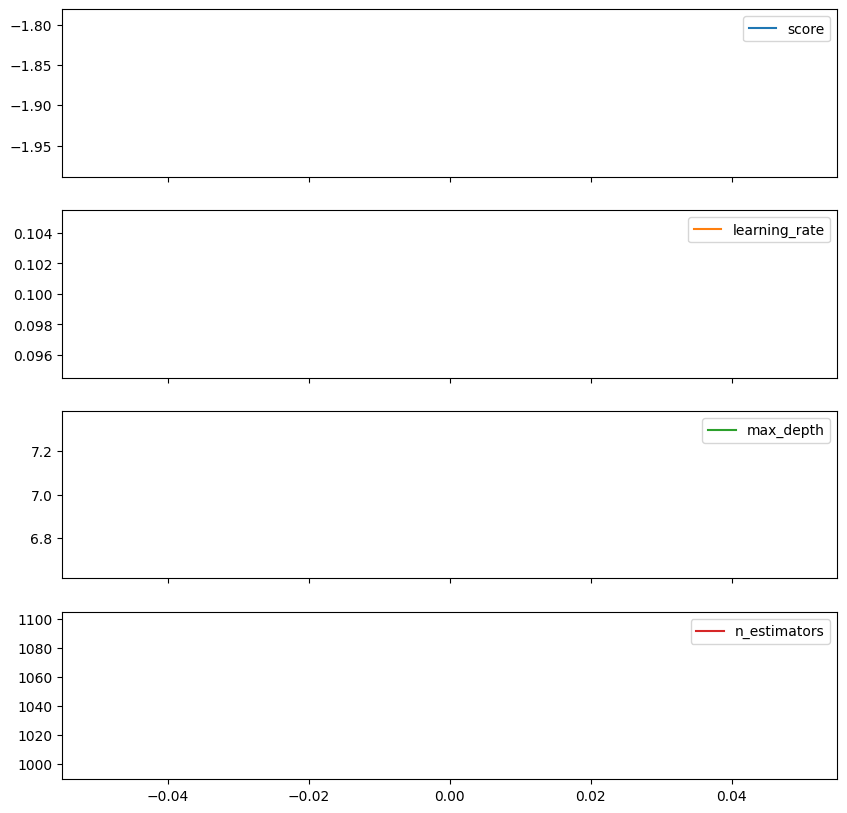

In [ ]:
rs_results_df=pd.DataFrame(np.transpose([rs1.cv_results_['mean_test_score'],
                                         rs1.cv_results_['param_learning_rate'].data,
                                         rs1.cv_results_['param_max_depth'].data,
                                         rs1.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
rs_results_df.plot(subplots=True,figsize=(10, 10))

In [ ]:
best_params['random_state'] = 42

# best 모델 인스턴스 생성(정의)
xgb_model2 = XGBRegressor(**best_params)

In [ ]:
seed_everything(42)
n_iter = 0
mae_lst = []

for train_index, valid_index in kf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  xgb_model2.fit(train_x, train_y)
  valid_pred = xgb_model2.predict(valid_x) # 예측값

  # 평가
  mae = mean_absolute_error(valid_y, valid_pred)
  mae_lst.append(mae)
  print(f'{n_iter} 번째 Stratified K-Fold MAE: {mae}')

# 최종 평가
print('-'*50)
print(f'교차 검증 MAE: {np.mean(mae_lst)}')

1 번째 Stratified K-Fold MAE: 1.8630830412603097
2 번째 Stratified K-Fold MAE: 1.8981515915834921
3 번째 Stratified K-Fold MAE: 1.8967668222868068
4 번째 Stratified K-Fold MAE: 1.9151195568706743
5 번째 Stratified K-Fold MAE: 1.8661651591362785
6 번째 Stratified K-Fold MAE: 1.9013571589021105
7 번째 Stratified K-Fold MAE: 1.8580503563734225
8 번째 Stratified K-Fold MAE: 1.8728734385647596
9 번째 Stratified K-Fold MAE: 1.891635788388019
--------------------------------------------------
교차 검증 MAE: 1.8848003237073192


## Light GBM


### model 2

In [ ]:
from lightgbm import LGBMRegressor, plot_importance

hp = {
    "random_state" : 42,
    "verbose": -1, # 로그
}
lgb_model2 = LGBMRegressor(**hp)

In [ ]:
n_iter=3 # 몇번 hp조합을 찾을 것인가?
scoring = 'neg_mean_absolute_error' # 어떤 평가지표를 사용할 것인가?
hp={
    "max_depth" : np.linspace(5,12,8,dtype = int), # 깊이
    "n_estimators" : np.linspace(800,1200,100, dtype = int), # 부스팅 단계수
    "learning_rate" : np.logspace(-3, -1, 3)
}

# HPO 인스턴스 생성
rs1=RandomizedSearchCV(lgb_model2, hp, scoring=scoring, n_iter=n_iter, n_jobs=-1, cv=kf, verbose=False)
# 학습 (best hp 조합 찾기)
rs1.fit(train_features, train_target)

# 학습 결과 (best hp 조합일 때,)
rs1.best_score_

-2.2967049277683365

In [ ]:
best_params = rs1.best_params_
best_params

{'n_estimators': 1179, 'max_depth': 9, 'learning_rate': 0.01}

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

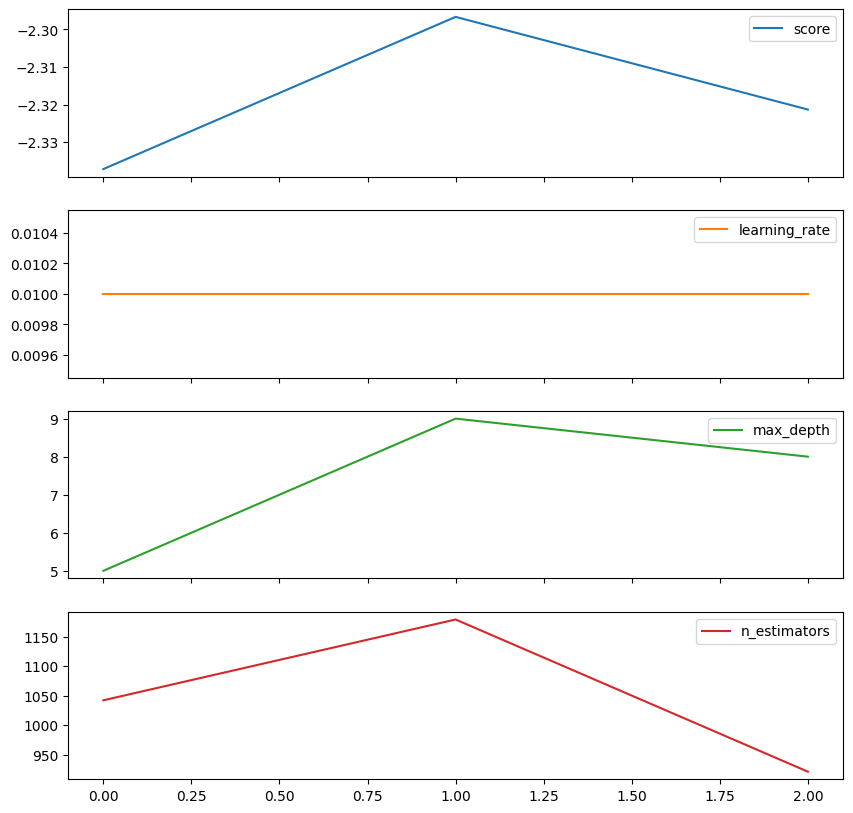

In [ ]:
rs_results_df=pd.DataFrame(np.transpose([rs1.cv_results_['mean_test_score'],
                                         rs1.cv_results_['param_learning_rate'].data,
                                         rs1.cv_results_['param_max_depth'].data,
                                         rs1.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
rs_results_df.plot(subplots=True,figsize=(10, 10))

In [ ]:
best_params['random_state'] = 42
best_params['verbose'] = -1

# best 모델 인스턴스 생성(정의)
lgb_model2 = LGBMRegressor(**best_params)

In [ ]:
n_iter = 0
accuracy_lst = []
mae_lst = []

for train_index, valid_index in kf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  lgb_model2.fit(train_x, train_y)
  valid_pred = lgb_model2.predict(valid_x) # 예측값

  # 평가
  mae = mean_absolute_error(valid_y, valid_pred)
  mae_lst.append(mae)
  print(f'{n_iter} 번째 Stratified K-Fold MAE: {mae}')

# 최종 평가
print('-'*50)
print(f'교차 검증 MAE: {np.mean(mae_lst)}')

1 번째 Stratified K-Fold MAE: 2.3053534657424217
2 번째 Stratified K-Fold MAE: 2.3070184886447236
3 번째 Stratified K-Fold MAE: 2.3217777115887053
4 번째 Stratified K-Fold MAE: 2.254280141769224
5 번째 Stratified K-Fold MAE: 2.302934434270567
6 번째 Stratified K-Fold MAE: 2.3363632427408336
7 번째 Stratified K-Fold MAE: 2.305850243544115
8 번째 Stratified K-Fold MAE: 2.2920285953653674
9 번째 Stratified K-Fold MAE: 2.2447380262490695
--------------------------------------------------
교차 검증 MAE: 2.2967049277683365


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45380 (\N{HANGUL SYLLABLE NYEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


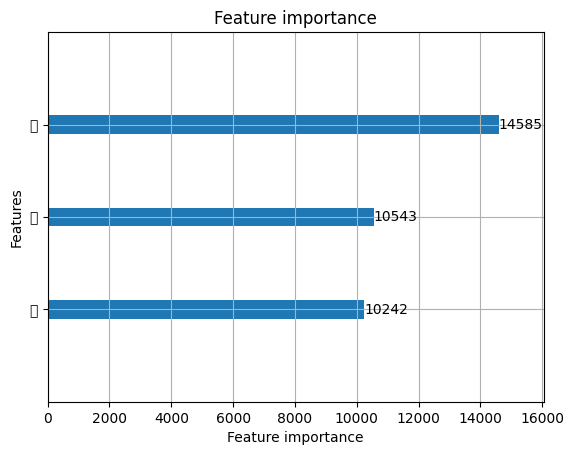

In [ ]:
plot_importance(lgb_model2)
plt.show()

## Catboost

### model 2

In [ ]:
from catboost import CatBoostRegressor
hp = {
    "random_state" : 42,
    "verbose": 0, # 로그
}
cat_model2 = CatBoostRegressor(**hp)

In [ ]:
n_iter=3 # 몇번 hp조합을 찾을 것인가?
scoring = 'neg_mean_absolute_error' # 어떤 평가지표를 사용할 것인가?
hp={
    "max_depth" : np.linspace(5,12,8,dtype = int), # 깊이
    "n_estimators" : np.linspace(100,500,100, dtype = int), # 부스팅 단계수
    "learning_rate" : np.logspace(-3, -1, 3)
}

# HPO 인스턴스 생성
rs1=RandomizedSearchCV(cat_model2, hp, scoring=scoring, n_iter=n_iter, n_jobs=-1, cv=kf, verbose=False)
# 학습 (best hp 조합 찾기)
rs1.fit(train_features, train_target)

# 학습 결과 (best hp 조합일 때,)
rs1.best_score_

-2.1509855305175867

In [ ]:
best_params = rs1.best_params_
best_params

{'n_estimators': 378, 'max_depth': 10, 'learning_rate': 0.1}

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

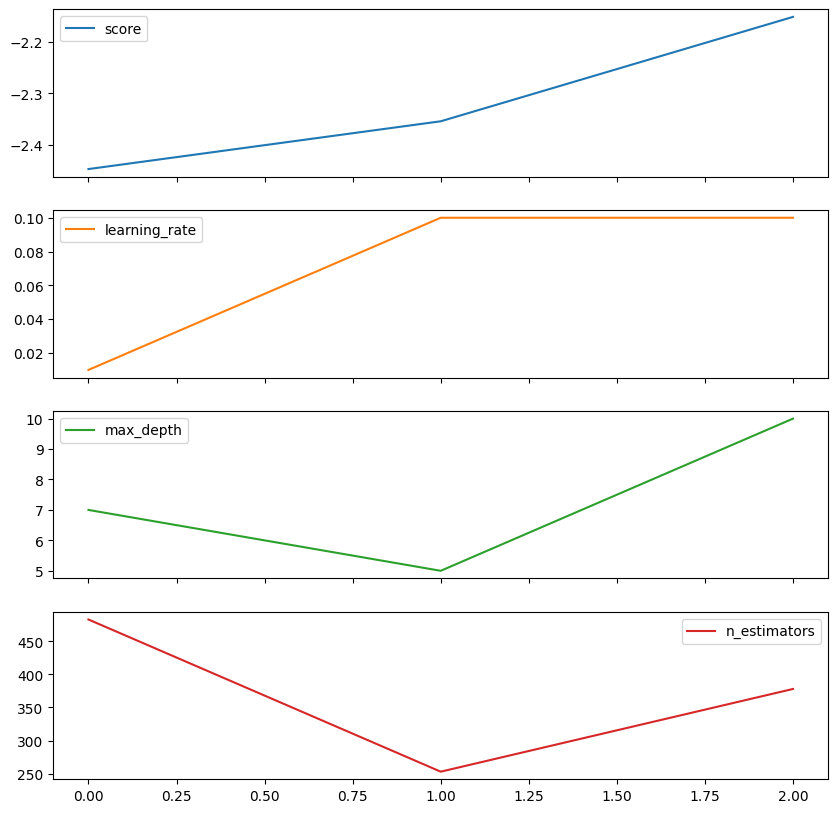

In [ ]:
rs_results_df=pd.DataFrame(np.transpose([rs1.cv_results_['mean_test_score'],
                                         rs1.cv_results_['param_learning_rate'].data,
                                         rs1.cv_results_['param_max_depth'].data,
                                         rs1.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
rs_results_df.plot(subplots=True,figsize=(10, 10))

In [ ]:
best_params['random_state'] = 42
best_params['verbose'] = 0

# best 모델 인스턴스 생성(정의)
cat_model2 = CatBoostRegressor(**best_params)

In [ ]:
n_iter = 0
accuracy_lst = []
mae_lst = []

for train_index, valid_index in kf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  cat_model2.fit(train_x, train_y)
  valid_pred = cat_model2.predict(valid_x) # 예측값

  # 평가
  mae = mean_squared_error(valid_y, valid_pred, squared=False)
  mae_lst.append(mae)
  print(f'{n_iter} 번째 Stratified K-Fold MAE: {mae}')

# 최종 평가
print('-'*50)
print(f'교차 검증 MAE: {np.mean(mae_lst)}')

1 번째 Stratified K-Fold MAE: 2.7973369761532405
2 번째 Stratified K-Fold MAE: 2.793147739150884
3 번째 Stratified K-Fold MAE: 2.845089653701181
4 번째 Stratified K-Fold MAE: 2.748305850747432
5 번째 Stratified K-Fold MAE: 2.7861212885630633
6 번째 Stratified K-Fold MAE: 2.8277725646735354
7 번째 Stratified K-Fold MAE: 2.791934360836523
8 번째 Stratified K-Fold MAE: 2.759816333207309
9 번째 Stratified K-Fold MAE: 2.724905513025925
--------------------------------------------------
교차 검증 MAE: 2.7860478088954546


Text(0.5, 1.0, 'Feature Importance')

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 45380 (\N{HANGUL SYLLABLE NYEON}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45380 (\N{HANGUL SYLLABLE NYEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50900 (\N{HANGU

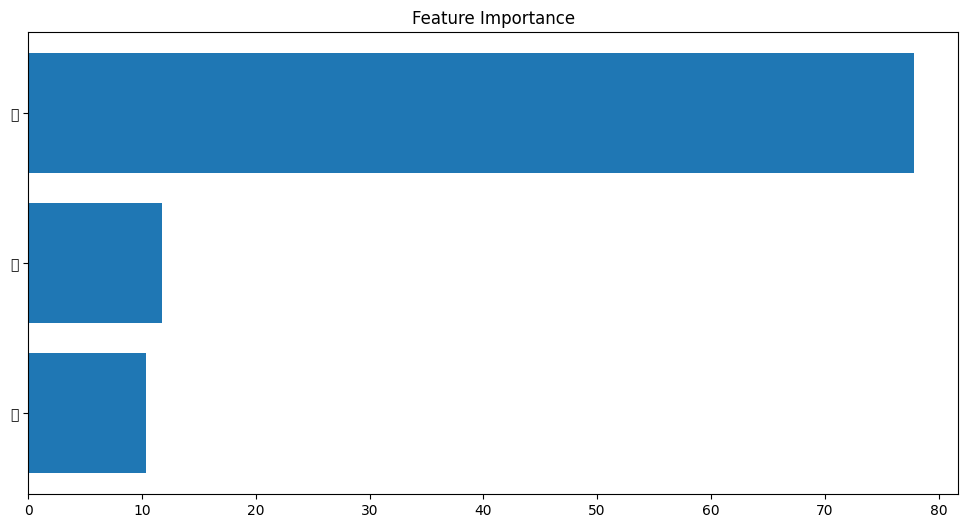

In [ ]:
feature_importance = cat_model2.feature_importances_
sorted_idx = np.argsort(feature_importance)

fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
# plt.yticks(range(len(sorted_idx)), np.array(range(len(train_x)))[sorted_idx])
# 변수명이 있다면, 아래와 같이...
plt.yticks(range(len(sorted_idx)), np.array(train_x.columns)[sorted_idx])
plt.title('Feature Importance')

## RandomForest

### model 2

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rfr_hp2 = {
    "random_state" : 42,
    "verbose": 0, # 로그
}
rfr_model2 = RandomForestRegressor(**rfr_hp2)

In [ ]:
n_iter=5 # 몇번 hp조합을 찾을 것인가?
scoring = 'neg_mean_absolute_error' # 어떤 평가지표를 사용할 것인가?
rfr_hp2={
    "max_depth" : np.linspace(5,12,8,dtype = int), # 깊이
    "n_estimators" : np.linspace(100,500,100, dtype = int), # 부스팅 단계수
}

# HPO 인스턴스 생성
rs1 = RandomizedSearchCV(RandomForestRegressor(), rfr_hp2, scoring=scoring, n_iter=n_iter, n_jobs=-1, cv=kf, verbose=3)
# 학습 (best hp 조합 찾기)
rs1.fit(train_features, train_target)

# 학습 결과 (best hp 조합일 때,)
rs1.best_score_

Fitting 9 folds for each of 5 candidates, totalling 45 fits


-2.311003089586746

In [ ]:
rfr_best_params = rs1.best_params_
rfr_best_params

{'n_estimators': 366, 'max_depth': 9}

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

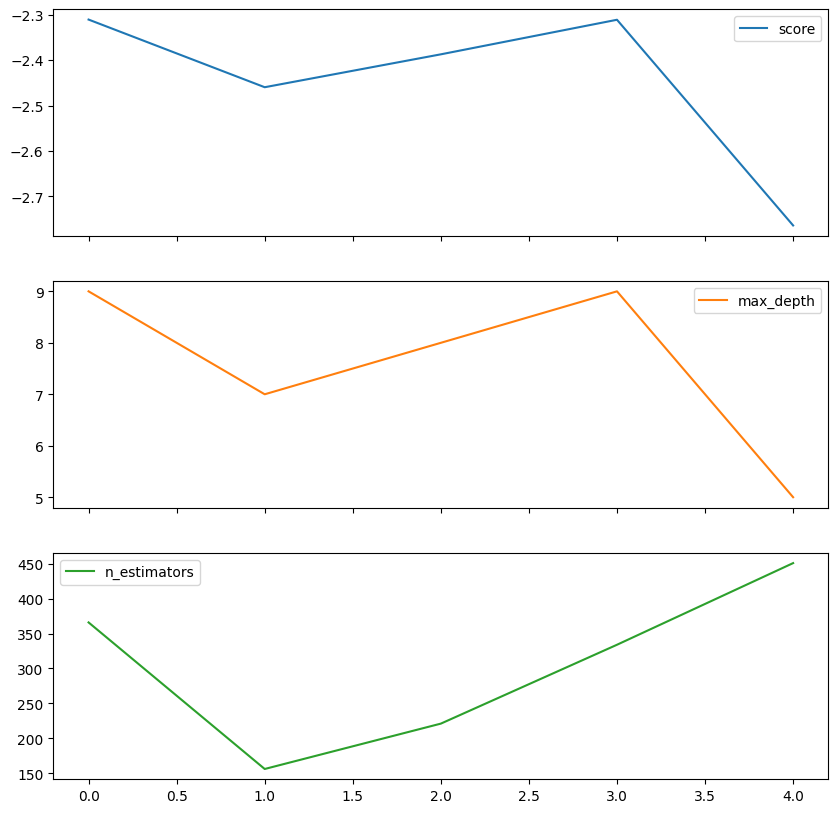

In [ ]:
rs_results_df=pd.DataFrame(np.transpose([rs1.cv_results_['mean_test_score'],
                                         rs1.cv_results_['param_max_depth'].data,
                                         rs1.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'max_depth', 'n_estimators'])
rs_results_df.plot(subplots=True,figsize=(10, 10))

In [ ]:
rfr_best_params['random_state'] = 42
rfr_best_params['verbose'] = 0

# best 모델 인스턴스 생성(정의)
rfr_model2 = RandomForestRegressor(**rfr_best_params)

In [ ]:
n_iter = 0
accuracy_lst = []
mae_lst = []

for train_index, valid_index in kf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  rfr_model2.fit(train_x, train_y)
  valid_pred = rfr_model2.predict(valid_x) # 예측값

  # 평가
  rmse = mean_squared_error(valid_y, valid_pred, squared=False)
  mae_lst.append(rmse)
  print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(mae_lst)}')

1 번째 Stratified K-Fold RMSE: 2.9532230761342393
2 번째 Stratified K-Fold RMSE: 3.030461827286179
3 번째 Stratified K-Fold RMSE: 3.0232514393377192
4 번째 Stratified K-Fold RMSE: 2.942866941505409
5 번째 Stratified K-Fold RMSE: 3.0196364267144085
6 번째 Stratified K-Fold RMSE: 3.0197392234910994
7 번째 Stratified K-Fold RMSE: 2.9895534201953278
8 번째 Stratified K-Fold RMSE: 2.950731503332564
9 번째 Stratified K-Fold RMSE: 2.9018739578765707
--------------------------------------------------
교차 검증 RMSE: 2.9812597573192794


# Voting

In [ ]:
from sklearn.ensemble import VotingRegressor

# Voting Regressor 정의
voting_reg = VotingRegressor(estimators=[
    ('xgb', xgb_model2),
    ('cat', cat_model2),
    ('lgb',lgb_model2),
    ('forest', rfr_model2)
])

n_iter = 0
rmse_lst = []

for train_index, valid_index in kf.split(train_features, train_target):
    n_iter += 1
    # 학습용, 검증용 데이터 구성
    train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
    train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

    # Voting Regressor 학습
    voting_reg.fit(train_x, train_y)

    # 검증 데이터에 대한 예측
    valid_pred = voting_reg.predict(valid_x)

    # 평가
    rmse = mean_squared_error(valid_y, valid_pred, squared=False)
    rmse_lst.append(rmse)
    print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

1 번째 Stratified K-Fold RMSE: 2.695641555527193
2 번째 Stratified K-Fold RMSE: 2.718164644509936
3 번째 Stratified K-Fold RMSE: 2.737503051331457
4 번째 Stratified K-Fold RMSE: 2.675951610402557
5 번째 Stratified K-Fold RMSE: 2.705280035969256
6 번째 Stratified K-Fold RMSE: 2.737191725144711
7 번째 Stratified K-Fold RMSE: 2.700991144198034
8 번째 Stratified K-Fold RMSE: 2.6777318792499947
9 번째 Stratified K-Fold RMSE: 2.6435134469162764
--------------------------------------------------
교차 검증 RMSE: 2.699107677027713


In [ ]:
voting_reg

VotingRegressor(estimators=[('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate...
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=1047, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=42, ...)),
                            ('cat',
                             <catboost.core.CatBoostRegressor object at 0x7e401d117f10>),
                            ('lgb',
                             LGBMRegressor(learning_rate=0.01, max_depth=9,
                                           n_estimators=1179, random_state=42,
                                           verbose=-1)),
                            ('forest',
                             RandomForestRegressor(max_depth=9,
                                                   n_estimators=366,
                                                   random_state=42))])

In [ ]:
pred = voting_reg.predict(train_x)

# RMSE 계산
rmse = np.sqrt(mean_squared_error(train_y, pred))
print(f'RMSE: {rmse}')

RMSE: 2.2756119430244057


In [ ]:
pred_df = pd.DataFrame(pred, columns=['ECLO'])

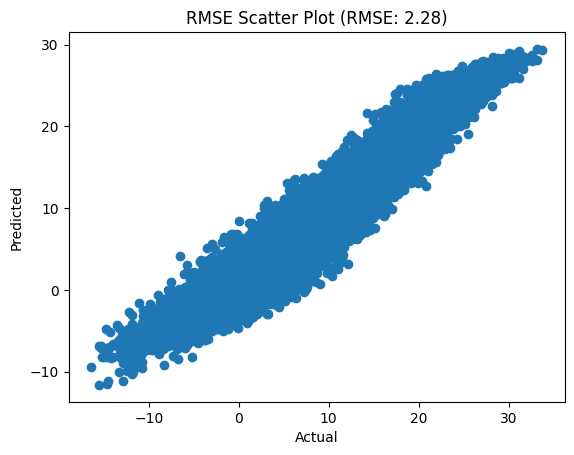

In [ ]:
import matplotlib.pyplot as plt

# train_y와 pred의 RMSE를 계산
rmse = np.sqrt(mean_squared_error(train_y, pred))

# 산포도 그래프 생성
plt.scatter(train_y, pred)

# 그래프에 제목과 x축, y축 레이블 추가
plt.title(f'RMSE Scatter Plot (RMSE: {rmse:.2f})')
plt.xlabel('Actual')
plt.ylabel('Predicted')

# 그래프 표시
plt.show()

## **Submission 양식 확인**

sample_submission.csv file 데이터(sample_submission)를 그대로 복사한 후,
양식의 'ECLO' 컬럼에 test_x에 대한 ECLO(y) 예측값을 입력합니다

In [ ]:
prediction =  voting_reg.predict(test_feature)

In [ ]:
baseline_submission = sample_submission.copy()
baseline_submission['평균기온'] = prediction
baseline_submission

,일시,평균기온
0,2023-01-01,-3.200896
1,2023-01-02,-2.499541
2,2023-01-03,-2.641540
3,2023-01-04,-3.033472
4,2023-01-05,-3.214718
...,...,...
353,2023-12-20,-3.379427
354,2023-12-21,-2.542901
355,2023-12-22,-5.018810
356,2023-12-23,-6.625913


## **답안지 저장 및 제출하기**

In [ ]:
baseline_submission.to_csv('Voting_Submission.csv', index=False)

## 다른거

In [ ]:
prediction =  lgb_model2.predict(test_feature)
baseline_submission = sample_submission.copy()
baseline_submission['평균기온'] = prediction
baseline_submission.to_csv('Lgb_Submission.csv', index=False)

In [ ]:
prediction =  cat_model2.predict(test_feature)
baseline_submission = sample_submission.copy()
baseline_submission['평균기온'] = prediction
baseline_submission.to_csv('Cat_Submission.csv', index=False)